## Introduction to Deep Learning 
# Exercise with Keras and solution


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import utils_plot as uplot
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, log_loss

%matplotlib inline  

## Utilities

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, np.where(ypred > 0.5, 1, 0)), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, np.where(ypred > 0.5, 1, 0)))
    print("Classification Report:")
    print(classification_report(ytest, np.where(ypred > 0.5, 1, 0)))

In [57]:
def drow_history_list(history_list, history_names=None,  metric=None):
    
    if metric is None:
        metric = 'loss'
        
    leg = []
    if history_names is not None:
        for n in history_names:
            leg.append('train ' + n)
            leg.append('test ' + n)
    else:
        for n in range(len(history_list)):
            leg.append('train ' + str(n))
            leg.append('test ' + str(n))
            
    for hist in history_list:
        
        plt.plot(hist.history[metric])
        plt.plot(hist.history['val_'+ metric], '--', linewidth=2)
        
        
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(leg)
    plt.show()  

## Exercise - Parkinson classification

* Can you improve the result ?
* Try different optimizers, Adadelta, Adam
* Try different batch sized.

* My best result was:

Accuracy: 0.73077, Cohen's Kappa Score: 0.46054<br>
Confusion Matrix:<br>
[[107  44]<br>
 [ 40 121]]<br>
Classification Report:<br>
              precision    recall  f1-score   support<br>

           0       0.73      0.71      0.72       151
           1       0.73      0.75      0.74       161


## Lets start Keras
In the Mnist classification example, we saw that the net basically learn templates.<br>
This is not robust enough for generalization. <br>
To generalize, we want the neural network to learn **features**. <br>
For that we will need deeper and more complexed networks.<br>
Lets build our first neural network with Keras.

In [23]:
import keras
# Keras has many build in data sets
from keras.datasets import mnist
# Sequential is the basic feed forward neural network (FFN)
from keras.models import Sequential
# Dense is fully connected layer
# Dropout is a "noising" layer, to prevent over feet.
from keras.layers import Dense, Dropout
# Read about optimizers in keras documentation
from keras.optimizers import RMSprop
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

## Parkinson binary classification example
### Create, normalize and split data

In [27]:
df = pd.read_csv('data\\parkinson.txt', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,...,187.576,160,159,0.006065,0.000416,0.000,0,0.000,23,1
1,1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,...,234.505,170,169,0.005181,0.000403,2.247,0,0.000,23,1
2,1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,...,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178,23,1
3,1,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,...,220.230,94,92,0.004910,0.000320,0.000,0,0.000,23,1
4,1,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,...,225.162,117,114,0.004757,0.000380,18.182,1,13.318,23,1


In [28]:
X = df[df.columns[1:27]]
y=df[28]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=42)

X_train.shape

C:\Users\naomi\Miniconda3\envs\py36\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\naomi\Miniconda3\envs\py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(728, 26)

### Build and compile keras model - Adadelta optimizer

In [29]:
np.random.seed(1235)

batch_size = 20
epochs = 30

def get_model(lsize=64, optimizer=RMSprop()):
    model = Sequential()
    model.add(Dense(lsize, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.1))
    model.add(Dense(lsize, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

model=get_model(optimizer=optimizers.Adadelta())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1728      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [30]:
checkpoint = ModelCheckpoint('best_model_e40_b20_oAdam.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint],
                    validation_data=(X_test, y_test))


Train on 728 samples, validate on 312 samples
Epoch 1/30
728/728 [==============================] - 1s 1ms/step - loss: 0.6710 - acc: 0.5755 - val_loss: 0.6477 - val_acc: 0.6538

Epoch 00001: val_loss improved from inf to 0.64770, saving model to best_model_e40_b20_oAdam.h5
Epoch 2/30
728/728 [==============================] - 0s 134us/step - loss: 0.6347 - acc: 0.6305 - val_loss: 0.6362 - val_acc: 0.6538

Epoch 00002: val_loss improved from 0.64770 to 0.63622, saving model to best_model_e40_b20_oAdam.h5
Epoch 3/30
728/728 [==============================] - 0s 132us/step - loss: 0.6163 - acc: 0.6538 - val_loss: 0.6195 - val_acc: 0.6795

Epoch 00003: val_loss improved from 0.63622 to 0.61948, saving model to best_model_e40_b20_oAdam.h5
Epoch 4/30
728/728 [==============================] - 0s 110us/step - loss: 0.6040 - acc: 0.6525 - val_loss: 0.6139 - val_acc: 0.6635

Epoch 00004: val_loss improved from 0.61948 to 0.61386, saving model to best_model_e40_b20_oAdam.h5
Epoch 5/30
728/728 [

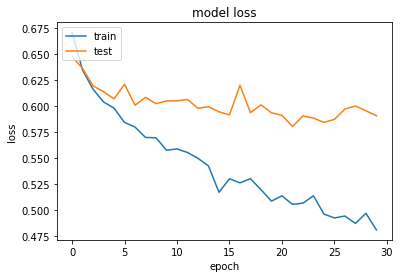

In [31]:
uplot.drow_history(history, 'loss')

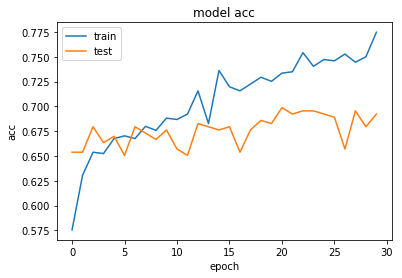

In [32]:
uplot.drow_history(history, 'acc')

In [33]:

model_best = get_model(optimizer=optimizers.Adadelta())
model_best.load_weights('best_model_e40_b20_oAdam.h5')

## Evaluate model

In [34]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5907578636438419
Test accuracy: 0.692307690779368


In [35]:
score = model_best.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5805147595894642
Test accuracy: 0.6923076938360165


## Predict

In [36]:
pred_test = model.predict(X_test)
y_pred_test = np.where(pred_test > 0.5, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.69231, Cohen's Kappa Score: 0.37990
Confusion Matrix:
[[ 87  64]
 [ 32 129]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.58      0.64       151
           1       0.67      0.80      0.73       161

   micro avg       0.69      0.69      0.69       312
   macro avg       0.70      0.69      0.69       312
weighted avg       0.70      0.69      0.69       312



In [37]:
pred_test = model_best.predict(X_test)
y_pred_test = np.where(pred_test > 0.5, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.69231, Cohen's Kappa Score: 0.38297
Confusion Matrix:
[[ 99  52]
 [ 44 117]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       151
           1       0.69      0.73      0.71       161

   micro avg       0.69      0.69      0.69       312
   macro avg       0.69      0.69      0.69       312
weighted avg       0.69      0.69      0.69       312



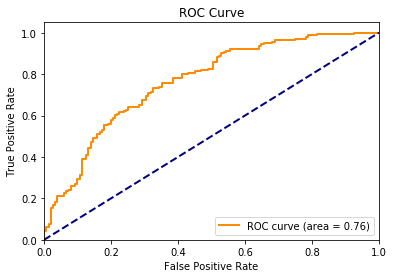

In [38]:
uplot.drow_roc_curve(y_test, model.predict(X_test))

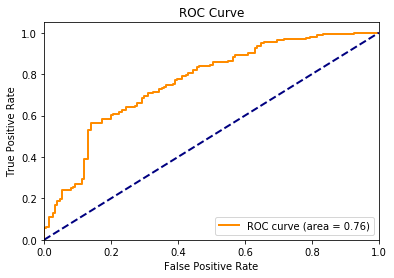

In [39]:
uplot.drow_roc_curve(y_test, model_best.predict(X_test))

In [40]:
pred_test = model_best.predict(X_test)
y_pred_test = np.where(pred_test > 0.625, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.70513, Cohen's Kappa Score: 0.41542
Confusion Matrix:
[[129  22]
 [ 70  91]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       151
           1       0.81      0.57      0.66       161

   micro avg       0.71      0.71      0.71       312
   macro avg       0.73      0.71      0.70       312
weighted avg       0.73      0.71      0.70       312




### Adam optimizer.

In [41]:
batch_size = 20
epochs = 10

model = get_model(lsize=64, optimizer=keras.optimizers.Adam(lr=0.01))                  

In [42]:
history_adam = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))


Train on 728 samples, validate on 312 samples
Epoch 1/10
728/728 [==============================] - 1s 960us/step - loss: 0.6915 - acc: 0.5838 - val_loss: 0.6504 - val_acc: 0.5705
Epoch 2/10
728/728 [==============================] - 0s 197us/step - loss: 0.6305 - acc: 0.6291 - val_loss: 0.6085 - val_acc: 0.6859
Epoch 3/10
728/728 [==============================] - 0s 142us/step - loss: 0.5910 - acc: 0.6703 - val_loss: 0.6233 - val_acc: 0.6506
Epoch 4/10
728/728 [==============================] - 0s 178us/step - loss: 0.5857 - acc: 0.6731 - val_loss: 0.6205 - val_acc: 0.6571
Epoch 5/10
728/728 [==============================] - 0s 178us/step - loss: 0.5777 - acc: 0.6799 - val_loss: 0.6014 - val_acc: 0.6699
Epoch 6/10
728/728 [==============================] - 0s 304us/step - loss: 0.5540 - acc: 0.7198 - val_loss: 0.6190 - val_acc: 0.6731
Epoch 7/10
728/728 [==============================] - 0s 232us/step - loss: 0.5837 - acc: 0.6827 - val_loss: 0.6059 - val_acc: 0.6763
Epoch 8/10
728/7

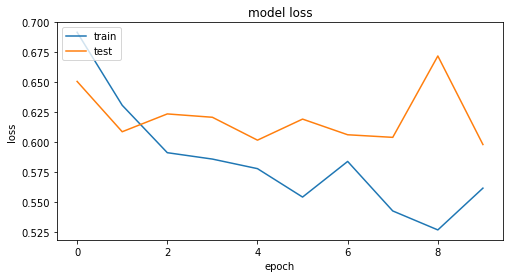

In [43]:
from IPython.core.pylabtools import figsize
figsize(8,4)
uplot.drow_history(history_adam,metric='loss')

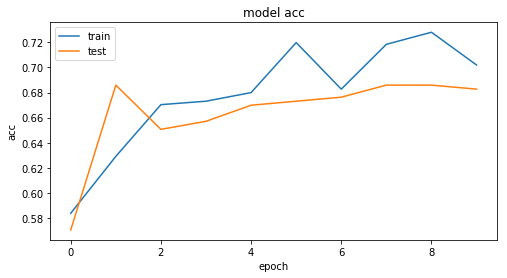

In [44]:
uplot.drow_history(history_adam,metric='acc')

In [45]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5977941491664984
Test accuracy: 0.682692309220632


## Predict

In [46]:
pred_test = model.predict(X_test)
y_pred_test = np.where(pred_test > 0.5, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.68269, Cohen's Kappa Score: 0.36224
Confusion Matrix:
[[ 92  59]
 [ 40 121]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       151
           1       0.67      0.75      0.71       161

   micro avg       0.68      0.68      0.68       312
   macro avg       0.68      0.68      0.68       312
weighted avg       0.68      0.68      0.68       312



In [47]:
pred_test = model.predict(X_test)
pred_test[0:5].flatten()

array([0.6980537 , 0.2071687 , 0.66862917, 0.6049404 , 0.5188317 ],
      dtype=float32)

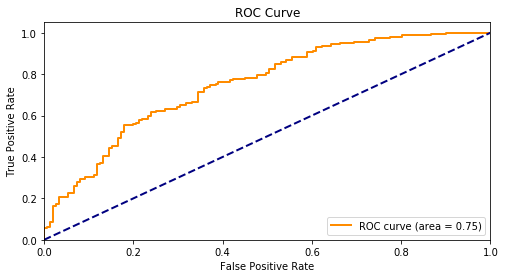

In [48]:
uplot.drow_roc_curve(y_test, pred_test)

### Result, until now SGD is the best optimizer

## Batch size

In [49]:
np.random.seed(1235)


epochs = 30
sgd = optimizers.SGD(lr=0.1)
model = get_model(lsize=64, optimizer=sgd)                  
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model_e50_b20_oSgd.h5', verbose=0, 
                             monitor='val_acc',
                             save_best_only=True, mode='auto') 

history_sgd_b20 = model.fit(X_train, y_train,
                    batch_size=20,
                    epochs=epochs,
                    verbose=0,callbacks=[checkpoint],
                    validation_data=(X_test, y_test))


In [50]:
model = get_model(lsize=64, optimizer=sgd)                  
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model_e50_b10_oSgd.h5', verbose=0, 
                             monitor='val_acc',
                             save_best_only=True, mode='auto') 

history_sgd_b10 = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=epochs,
                    verbose=0,callbacks=[checkpoint],
                    validation_data=(X_test, y_test))

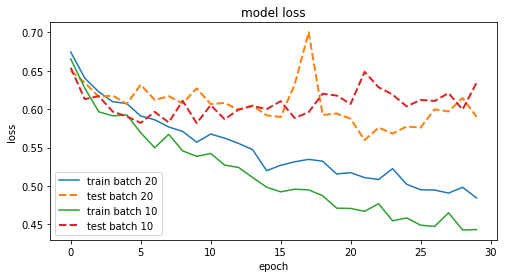

In [58]:
from IPython.core.pylabtools import figsize
figsize(8,4)
drow_history_list(history_list=[history_sgd_b20, history_sgd_b10], 
                  history_names=['batch 20', 'batch 10'],  metric=None)

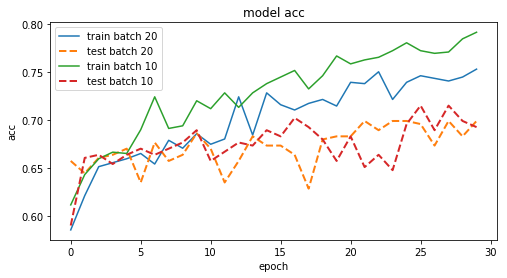

In [52]:
drow_history_list(history_list=[history_sgd_b20, history_sgd_b10], 
                  history_names=['batch 20', 'batch 10'],metric='acc')

In [53]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6344816654156415
Test accuracy: 0.6923076923076923


## Predict

In [54]:
pred_test = model.predict(X_test)
y_pred_test = np.where(pred_test > 0.5, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.69231, Cohen's Kappa Score: 0.38751
Confusion Matrix:
[[117  34]
 [ 62  99]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.77      0.71       151
           1       0.74      0.61      0.67       161

   micro avg       0.69      0.69      0.69       312
   macro avg       0.70      0.69      0.69       312
weighted avg       0.70      0.69      0.69       312



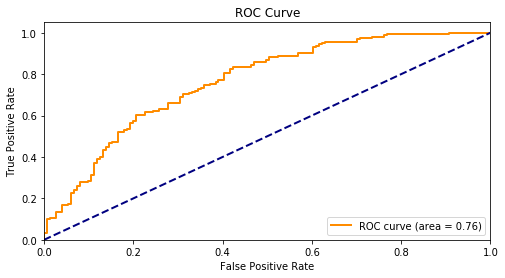

In [55]:
uplot.drow_roc_curve(y_test, model.predict(X_test))

Check best model

In [56]:
model_best = get_model(optimizer=optimizers.Adadelta())
model_best.load_weights('best_model_e50_b10_oSgd.h5')

pred_test = model_best.predict(X_test)
y_pred_test = np.where(pred_test > 0.5, 1, 0).flatten()
print_stats(y_test,y_pred_test )

Accuracy: 0.71474, Cohen's Kappa Score: 0.42737
Confusion Matrix:
[[100  51]
 [ 38 123]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       151
           1       0.71      0.76      0.73       161

   micro avg       0.71      0.71      0.71       312
   macro avg       0.72      0.71      0.71       312
weighted avg       0.72      0.71      0.71       312

